### Limma voom analysis of AD/PD dataset

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(50))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('adpd.atac.counts.txt.gz',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$chrom,data$start,data$end,sep="_")
data$chrom=NULL
data$start=NULL
data$end=NULL

data=data[rowSums(data)>0,]


In [3]:
head(data)

,ADAD_CAUD_00_0281,ADAD_CAUD_00_0387,ADAD_CAUD_01_0164,ADAD_CAUD_01_1400,ADAD_CAUD_06_0194,ADAD_CAUD_06_1486,ADAD_CAUD_07_0787,ADAD_CAUD_12829xx,ADAD_CAUD_23156xx,ADAD_CAUD_24281xx,⋯,LRRK_MDTG_01_39,LRRK_MDTG_04_10,LRRK_MDTG_10_37,LRRK_MDTG_13_60,LRRK_PTMN_01_39,LRRK_PTMN_04_10,LRRK_PTMN_10_37,LRRK_PTMN_13_60,LRRK_SUNI_04_10,LRRK_SUNI_10_37
chr1_9996_10236,12,16,22,12,14,20,12,22,16,10,⋯,3,2,14,18,0,4,12,9,22,26
chr1_180769_180986,6,13,7,4,7,10,6,11,4,10,⋯,3,4,8,9,2,11,7,4,10,10
chr1_181327_181563,1,6,4,2,10,6,1,10,1,3,⋯,1,5,2,14,0,4,7,4,8,18
chr1_183499_184320,25,15,18,28,5,43,46,60,19,35,⋯,2,57,53,65,10,43,34,22,63,56
chr1_184356_184577,7,6,6,1,6,11,6,11,5,9,⋯,5,17,12,18,1,13,7,4,23,15
chr1_190744_191148,84,95,136,110,43,163,97,186,66,158,⋯,6,70,122,46,8,78,46,36,79,93


In [4]:
#load the metadata
batches=read.table("batches.filtered.csv",header=TRUE,sep='\t')

In [5]:
tail(batches)

,Sample,Type,Group,Region,Cohort,Library,Gender
407,LRRK_PTMN_01_39,LRRK,ADPD,PTMN,PD,L022,Male
408,LRRK_PTMN_04_10,LRRK,ADPD,PTMN,PD,L041,Male
409,LRRK_PTMN_10_37,LRRK,ADPD,PTMN,PD,L033,Female
410,LRRK_PTMN_13_60,LRRK,ADPD,PTMN,PD,L061,Male
411,LRRK_SUNI_04_10,LRRK,ADPD,SUNI,PD,L035,Male
412,LRRK_SUNI_10_37,LRRK,ADPD,SUNI,PD,L045,Female


In [6]:
head(batches)

Sample,Type,Group,Region,Cohort,Library,Gender
ADAD_CAUD_00_0281,ADAD,GENA,CAUD,AD,L051,Male
ADAD_CAUD_00_0387,ADAD,GENA,CAUD,AD,L075,Female
ADAD_CAUD_01_0164,ADAD,GENA,CAUD,AD,L055,Male
ADAD_CAUD_01_1400,ADAD,GENA,CAUD,AD,L053,Male
ADAD_CAUD_06_0194,ADAD,GENA,CAUD,AD,L045,Male
ADAD_CAUD_06_1486,ADAD,GENA,CAUD,AD,L041,Male


## Normalize the data with voom 

In [7]:
tpm=voom(data,normalize.method = "quantile")
E=tpm$E


## Perform PCA analysis 

In [8]:
data.pca=prcomp(t(E))

In [9]:
var_explained=as.character(round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2))


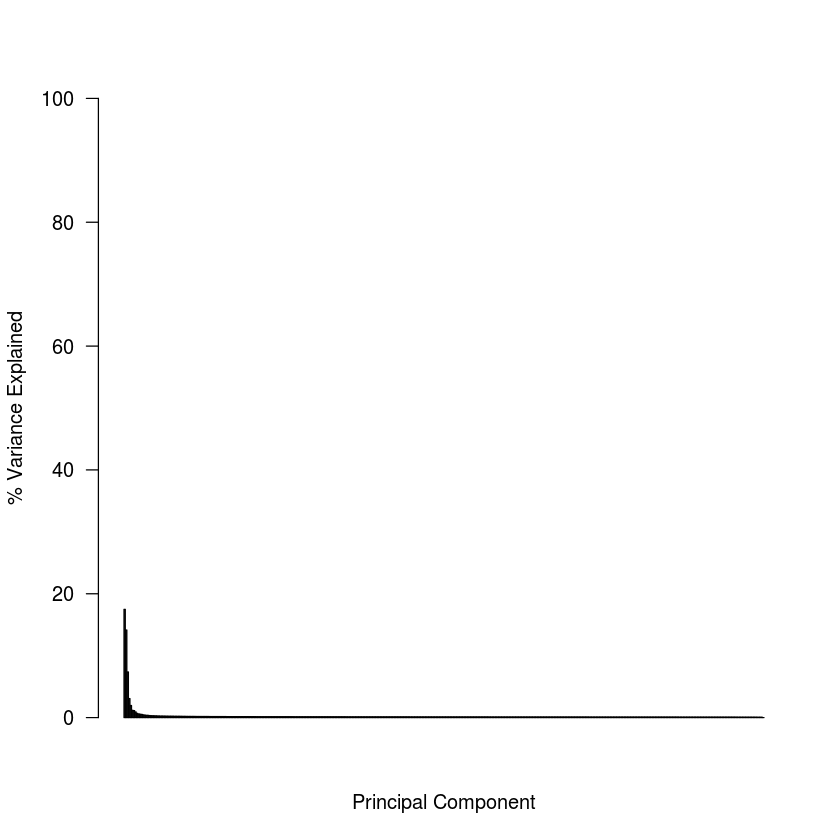

In [10]:
barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,ylab="% Variance Explained",xlab="Principal Component",ylim=c(0,100))

In [11]:
var_explained

[1] "17.48" "14.15" "7.37"  "3.07"  "1.95"  "1.18"  "1.13"  "0.91"  "0.69" 
 [10] "0.59"  "0.54"  "0.52"  "0.45"  "0.4"   "0.37"  "0.36"  "0.33"  "0.31" 
 [19] "0.3"   "0.29"  "0.28"  "0.27"  "0.25"  "0.25"  "0.24"  "0.24"  "0.23" 
 [28] "0.23"  "0.23"  "0.22"  "0.22"  "0.22"  "0.21"  "0.21"  "0.21"  "0.21" 
 [37] "0.21"  "0.2"   "0.2"   "0.2"   "0.2"   "0.19"  "0.19"  "0.19"  "0.19" 
 [46] "0.18"  "0.18"  "0.18"  "0.18"  "0.18"  "0.18"  "0.18"  "0.18"  "0.18" 
 [55] "0.17"  "0.17"  "0.17"  "0.17"  "0.17"  "0.17"  "0.17"  "0.17"  "0.17" 
 [64] "0.17"  "0.17"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16" 
 [73] "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.16"  "0.15" 
 [82] "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15" 
 [91] "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15"  "0.15" 
[100] "0.15"  "0.15"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14" 
[109] "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14" 
[118] "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14"  "0.14" 
[127] "0.14"  "0.14"  "0.14"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13" 
[136] "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13" 
[145] "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13" 
[154] "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13"  "0.13" 
[163] "0.13"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12" 
[172] "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12" 
[181] "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12" 
[190] "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12" 
[199] "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.12"  "0.11"  "0.11" 
[208] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[217] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[226] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[235] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[244] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[253] "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11"  "0.11" 
[262] "0.11"  "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[271] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[280] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[289] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[298] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[307] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"  
[316] "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.1"   "0.09"  "0.09"  "0.09" 
[325] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[334] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[343] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[352] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[361] "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09"  "0.09" 
[370] "0.09"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08" 
[379] "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08" 
[388] "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08"  "0.08" 
[397] "0.08"  "0.08"  "0.07"  "0.07"  "0.07"  "0.07"  "0.07"  "0.07"  "0.07" 
[406] "0.07"  "0.07"  "0.07"  "0.06"  "0.06"  "0.06"  "0"

In [12]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)

In [13]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC410,PC411,PC412,Sample,Type,Group,Region,Cohort,Library,Gender
ADAD_CAUD_00_0281,-155.72611,-346.10147,31.073960,193.513639,-68.035807,-9.573019,5.058191,-81.273647,88.077764,-50.6306732,⋯,-2.36621409,-0.18699710,5.635169e-13,ADAD_CAUD_00_0281,ADAD,GENA,CAUD,AD,L051,Male
ADAD_CAUD_00_0387,122.02011,-361.15814,195.209855,64.721928,-86.838489,-198.103723,-164.532443,-91.565663,-65.139662,-48.0934895,⋯,-0.60176527,0.27680882,-1.059097e-11,ADAD_CAUD_00_0387,ADAD,GENA,CAUD,AD,L075,Female
ADAD_CAUD_01_0164,16.56254,-379.22792,383.875843,170.357458,-50.531897,-45.292813,-111.504401,-210.878764,42.886420,-32.7141625,⋯,-1.99541703,0.10707503,5.022778e-12,ADAD_CAUD_01_0164,ADAD,GENA,CAUD,AD,L055,Male
ADAD_CAUD_01_1400,152.05151,-512.30744,276.156752,202.008723,-53.313149,-32.682167,-8.384537,-102.750397,-35.003897,34.7062297,⋯,0.83605276,1.51140912,4.339189e-12,ADAD_CAUD_01_1400,ADAD,GENA,CAUD,AD,L053,Male
ADAD_CAUD_06_0194,219.24642,-537.99060,-165.241655,-20.645068,-26.418235,-74.483295,-13.120557,-116.952890,-36.154155,-13.4739693,⋯,1.10182763,0.86847605,-6.142240e-12,ADAD_CAUD_06_0194,ADAD,GENA,CAUD,AD,L045,Male
ADAD_CAUD_06_1486,166.97698,-397.20948,287.774754,149.523560,-82.584225,-51.689908,-45.680648,-164.384545,-7.259769,-45.2270367,⋯,-0.45868565,-0.91495485,3.127788e-12,ADAD_CAUD_06_1486,ADAD,GENA,CAUD,AD,L041,Male
ADAD_CAUD_07_0787,-154.83141,-197.08931,211.949446,88.885819,-41.515121,12.675353,-22.217336,-113.529254,-54.291652,19.4860133,⋯,-0.20302441,-0.70430923,1.863146e-13,ADAD_CAUD_07_0787,ADAD,GENA,CAUD,AD,L037,Male
ADAD_CAUD_12829xx,58.85736,-152.07432,422.541560,192.303263,-59.518282,-5.310724,-31.298075,-106.736243,63.801820,82.1519811,⋯,-1.53269255,-0.65233692,6.590399e-12,ADAD_CAUD_12829xx,ADAD,GENA,CAUD,AD,L009,Male
ADAD_CAUD_23156xx,-360.24602,-95.63719,56.506506,155.951876,-67.452026,-51.756100,-31.465433,96.115383,15.425023,-0.4099138,⋯,10.09718879,-1.47602789,-3.702311e-13,ADAD_CAUD_23156xx,ADAD,GENA,CAUD,AD,L053,Female
ADAD_CAUD_24281xx,195.74307,-567.24896,306.198232,193.215760,-32.739448,-41.380820,-122.603217,1.197908,-17.090896,21.3923696,⋯,-1.32055721,1.62835592,-2.277370e-12,ADAD_CAUD_24281xx,ADAD,GENA,CAUD,AD,L025,Female


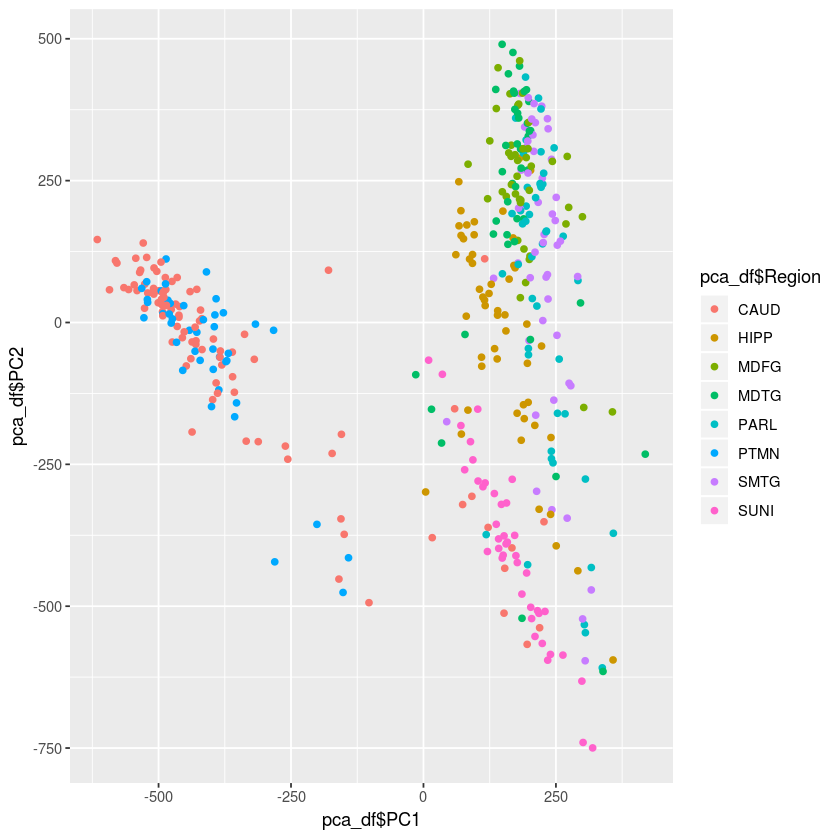

In [14]:
ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Region))+
geom_point()#,shape=pca_df$Region))
#+
#  xlab("PC1")+
#  ylab("PC2")+
#  theme_bw(20)+
#  scale_color_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'),name="Type"))
#p1
#svg("pca.1.2.svg",width = 8, height = 4, pointsize = 12)
#print(p1)
#dev.off()

In [15]:
p2=ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$Type,shape=pca_df$Region))+
  xlab("PC2")+
  ylab("PC3")+
  theme_bw(20)+
  scale_color_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'),name="Type")+
p2
svg("pca.2.3.svg",width = 8, height = 4, pointsize = 12)
print(p2)
dev.off()

ERROR: Error in eval(expr, envir, enclos): object 'p2' not found


In [ ]:
p3=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC3,color=pca_df$Type,shape=pca_df$Region))+
  xlab("PC1")+
  ylab("PC3")+
  theme_bw(20)+
  scale_color_manual(values=c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf'),name="Type")+
p3
svg("pca.1.3.svg",width = 8, height = 4, pointsize = 12)
print(p3)
dev.off()

In [ ]:
mod0=model.matrix(~1,data=batches)
mod1=model.matrix(~0+Type+Region+Cohort,data=batches)
sva.obj=sva(data$E,mod1,mod0,method="irw")
sur_var=data.frame(sva.obj$sv)

summary(lm(sva.obj$sv ~ batches$Type+batches$Region+batches$Cohort))
full.design.sv=cbind(mod1,sur_var)

In [ ]:
fit <- lmFit(data$E,full.design.sv)

In [ ]:
cont.matrix=makeContrasts(soft_vs_stiff="Sample100Pa - Sample2000Pa",
                          saha_soft_vs_stiff="Samplesaha_100Pa - Samplesaha_2000Pa",
                          soft_saha_vs_nosaha="Samplesaha_100Pa - Sample100Pa",
                          stiff_saha_vs_nosaha="Samplesaha_2000Pa - Sample2000Pa",
                          sahasoft_vs_stiff="Samplesaha_100Pa - Sample2000Pa",
                          sahastiff_vs_soft="Samplesaha_2000Pa - Sample100Pa",
                          levels=mod2)


In [ ]:
fit2=contrasts.fit(fit,cont.matrix)
e=eBayes(fit2)
comparisons=colnames(cont.matrix)
for(i in seq(1,length(comparisons)))
{
  tab<-topTable(e, number=nrow(e),coef=i,p.value = 1)
  if(nrow(tab)>0){
    names(tab)[1]=comparisons[i]
    write.table(tab,file=paste("diff_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = TRUE,col.names = TRUE)
    png(paste("volcano_peaks",comparisons[i],".png",sep=""))
    volcanoplot(e,coef=i,highlight =0,names=rownames(tab),main=comparisons[i])
    dev.off() 
  }
  else{
    write.table(tab,file=paste("diff_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = FALSE,col.names = FALSE)
  }
}